In [1]:
import math
import random
from collections import namedtuple, deque
from itertools import count

import torch
from torch import nn, optim
from torch.nn.functional import relu

import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [139]:
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ioff()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
from battleship.logic.game import Field

class BattleshipEnv:
    def __init__(self, size=10):
        self.size = size
        self.n_actions = size * size
        self.reset()

    def reset(self):
        self.field = Field(); self.field.auto_place()
        self.view = np.zeros((self.size, self.size), dtype=np.int8)
        self.remaining = sum(s.size for s in self.field.ships)
        self.done = False
        # Track which cells are part of sunken ships
        self.sank_mask = np.zeros((self.size, self.size), dtype=np.bool_)
        return self._get_obs()

    def _get_obs(self):
        # one-hot channels: unknown(0), miss(1), hit(2), sunk(3)
        v = self.view
        # Channel 0: unknown
        ch0 = (v == 0)
        # Channel 1: miss
        ch1 = (v == 1)
        # Channel 2: hit (not sunk)
        ch2 = (v == 2) & (~self.sank_mask)
        # Channel 3: sunk
        ch3 = self.sank_mask
        return np.stack([ch0, ch1, ch2, ch3], axis=0).astype(np.float32)

    def step(self, action):
        if self.done:
            raise RuntimeError("Episode done – call reset()")
        x, y = divmod(action, self.size)
        if self.view[x, y] != 0:
            raise RuntimeError("Should not happen")
            # self.done = True
            # return self._get_obs(), -5.0, True
        res = self.field.check((x, y))
        if res in ('hit','sank'):
            self.view[x, y] = 2
            reward = 5.0 if res=='hit' else 10.0
            self.remaining -= 1
            if res == 'sank':
                # Mark all cells of the last sunken ship in sank_mask
                last_sank_ship = self.field.sank[-1]
                for coord in last_sank_ship.status:
                    self.sank_mask[coord[0], coord[1]] = True
        else:
            self.view[x, y] = 1
            reward = -1.0
        if self.remaining == 0:
            self.done = True
            reward += 100.0
        return self._get_obs(), reward, self.done

    def legal_actions(self):
        return [i for i,v in enumerate(self.view.flat) if v==0]

In [4]:
env = BattleshipEnv()

In [6]:
state = env.reset()

In [7]:
env.field.cells

[[0, 0, 0, 0, 0, 0, 0, 4, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 4, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 4, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 1, 0, 2, 2, 2, 2, 0, 0, 0],
 [0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 5, 5, 0, 0],
 [0, 0, 3, 3, 3, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]

In [9]:
state, reward, done = env.step(7)
reward

5.0

In [14]:
state[1]

array([[0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [23]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions=100):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(100, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = relu(self.layer1(x))
        x = relu(self.layer2(x))

        return self.layer3(x)

In [15]:
class DQN(nn.Module):
    def __init__(self, n_observations=1, n_actions=100):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(64 * 10 * 10, 256)
        self.fc2 = nn.Linear(256, n_actions)

    def forward(self, x):
        # x: (batch, 1, 10, 10)
        # x = x.view(x.size(0), 1, 10, 10)
        x = relu(self.conv1(x))
        x = relu(self.conv2(x))
        x = relu(self.conv3(x))
        x = x.view(x.size(0), -1)  # flatten
        x = relu(self.fc1(x))
        return self.fc2(x)  # (batch, 100)

In [37]:
class DQN(nn.Module):
    def __init__(self, in_channels=4, n_actions=100):
        super().__init__()
        self.conv = nn.Sequential(
            nn.ZeroPad2d(2),
            nn.Conv2d(in_channels=4, out_channels=64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1),
            nn.Conv2d(64, 64, kernel_size=4, padding='same'),
            nn.ReLU()
        )
        self.head = nn.Sequential(
            nn.Linear(64 * 5 * 5, 256),  # Input is 64*5*5 = 1600
            nn.ReLU(),
            nn.Linear(256, n_actions)  # Output layer, no activation for Q-values
        )

    def forward(self, x):
        x = self.conv(x)
        # print(x.shape, x)
        # x = x.view(x.size(0), -1)
        x = x.flatten(start_dim=1)
        # print(x.shape, x)
        return self.head(x)

In [24]:
inputs = torch.arange(start=0, end=2*4*100, dtype=torch.float32).reshape(2, 4, 10, 10)
inputs

tensor([[[[  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.],
          [ 10.,  11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.],
          [ 20.,  21.,  22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.],
          [ 30.,  31.,  32.,  33.,  34.,  35.,  36.,  37.,  38.,  39.],
          [ 40.,  41.,  42.,  43.,  44.,  45.,  46.,  47.,  48.,  49.],
          [ 50.,  51.,  52.,  53.,  54.,  55.,  56.,  57.,  58.,  59.],
          [ 60.,  61.,  62.,  63.,  64.,  65.,  66.,  67.,  68.,  69.],
          [ 70.,  71.,  72.,  73.,  74.,  75.,  76.,  77.,  78.,  79.],
          [ 80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,  88.,  89.],
          [ 90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,  99.]],

         [[100., 101., 102., 103., 104., 105., 106., 107., 108., 109.],
          [110., 111., 112., 113., 114., 115., 116., 117., 118., 119.],
          [120., 121., 122., 123., 124., 125., 126., 127., 128., 129.],
          [130., 131., 132., 133., 134., 135., 136., 137., 138

In [25]:
model = DQN(in_channels=4, n_actions=100)

In [ ]:
outputs = model(inputs)

In [27]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [56]:
def select_action(state):
    global steps_done
    sample = random.random()
    # eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)    # TODO: change threshold formula
    if steps_done < EPS_WARMUP:
        eps_threshold = 0.9
    else:
        eps_threshold = max(EPS_END, EPS_START - (EPS_START - EPS_END) * (steps_done - EPS_WARMUP) / EPS_DECAY)  # Linear decay
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            q_values = q_net(state)
            legal = env.legal_actions()
            mask = torch.full(q_values.shape, float('-inf'), device=device)
            mask[0, legal] = 0  # Only legal actions are unmasked
            masked_q_values = q_values + mask
            return masked_q_values.max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.legal_actions()[random.randrange(len(env.legal_actions()))]]], device=device, dtype=torch.long)


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [294]:
def optimize_model():
    if len(memory) < batch_size:
        return
    transitions = memory.sample(batch_size)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None])

    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to q_net
    outputs = q_net(state_batch)
    # print(outputs.shape, outputs[0])
    # print(action_batch.shape, action_batch[0])
    state_action_values = outputs.gather(dim=1, index=action_batch)
    # print(state_action_values.shape, state_action_values[0])

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.


    # next_state_values = torch.zeros(batch_size, device=device)
    # with torch.no_grad():
    #     next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values


    # Compute the expected Q values
    # expected_state_action_values = (next_state_values * gamma) + reward_batch

    next_state_values = torch.zeros(batch_size, device=device)
    with torch.no_grad():
        # Double DQN: Select action using q_net, evaluate using target_net
        q_values_next = q_net(non_final_next_states)
        best_actions = q_values_next.max(1).indices.unsqueeze(1)
        q_values_next_target = target_net(non_final_next_states)
        next_state_values[non_final_mask] = q_values_next_target.gather(1, best_actions).squeeze(1)

    expected_state_action_values = (next_state_values * gamma) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_norm_(q_net.parameters(), 10)

    optimizer.step()
    # scheduler.step()


    # In optimize_model(), after optimizer.step():
    loss_history.append(loss.item())

In [295]:
lr = 5e-6
gamma = 0.99
tau = 0.005
batch_size = 128

steps_done = 0
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 500000
EPS_WARMUP = 10000
TARGET_UPDATE_STEPS = 20000

env = BattleshipEnv()
# n_observations = env.n_observations
n_actions = env.n_actions

q_net = DQN(in_channels=4, n_actions=100).to(device)
target_net = DQN(in_channels=4, n_actions=100).to(device)
target_net.load_state_dict(q_net.state_dict())

optimizer = optim.AdamW(q_net.parameters(), lr=lr, amsgrad=True)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=150000, gamma=0.5)

memory = ReplayMemory(100000)

In [296]:
# Add at the top
activation_stats = {}

def get_activation(name):
    def hook(model, input, output):
        activation_stats[name] = output.detach()
    return hook

# Register hooks after model creation
q_net.conv[1].register_forward_hook(get_activation('conv1'))
q_net.conv[3].register_forward_hook(get_activation('conv2'))
q_net.conv[6].register_forward_hook(get_activation('conv3'))
q_net.head[0].register_forward_hook(get_activation('fc1'))
q_net.head[2].register_forward_hook(get_activation('fc2'))

In [297]:
num_episodes = 5000
episode_durations = []
# Add at top of file
episode_rewards = []
loss_history = []

In [298]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter(log_dir='runs/battleship_experiment')

In [302]:
num_episodes

5000

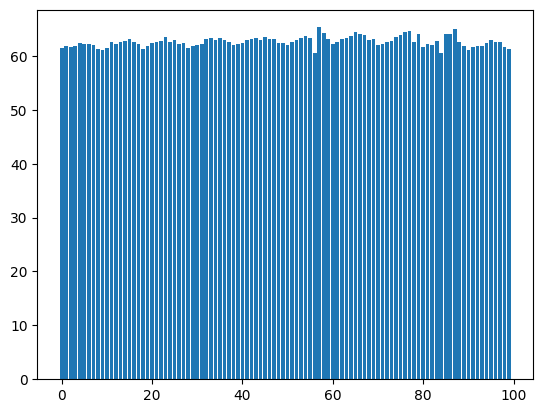

Ep 6003  avg_reward_20=128.15  avg_duration_20=87.85  avg_loss_100=3.6113


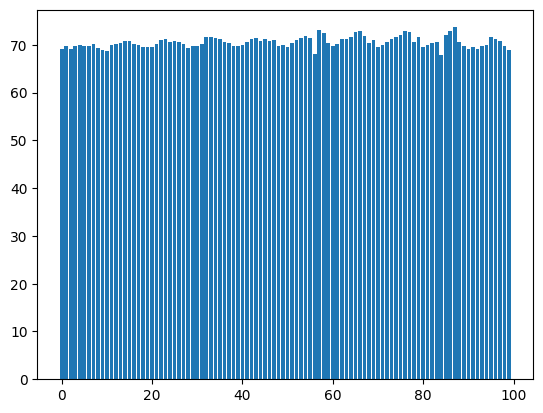

Ep 6053  avg_reward_20=129.45  avg_duration_20=86.55  avg_loss_100=3.6306


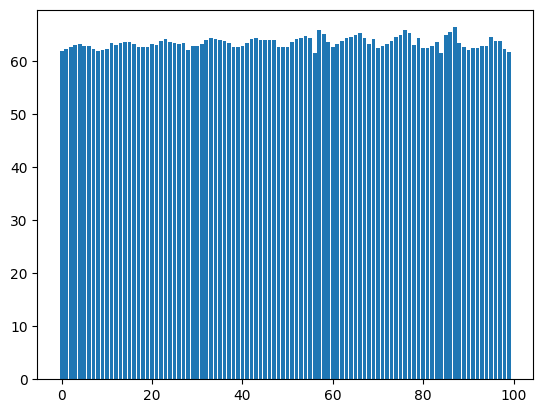

Ep 6103  avg_reward_20=128.95  avg_duration_20=87.05  avg_loss_100=3.3301
Weights moved at step: 540000


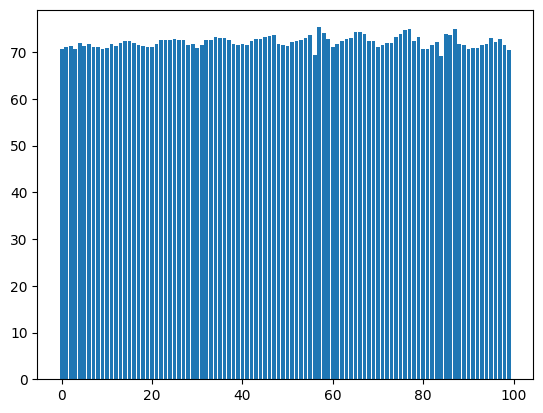

Ep 6153  avg_reward_20=127.60  avg_duration_20=88.40  avg_loss_100=4.0631


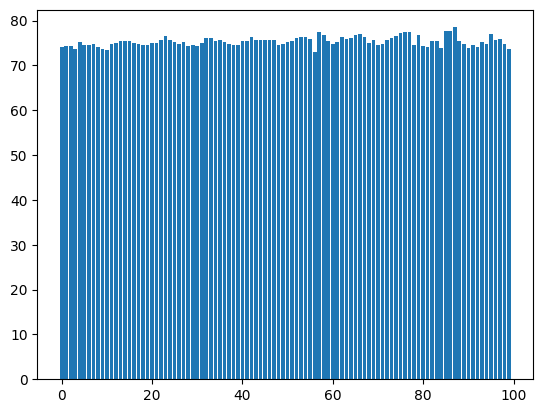

Ep 6203  avg_reward_20=128.20  avg_duration_20=87.80  avg_loss_100=3.8985


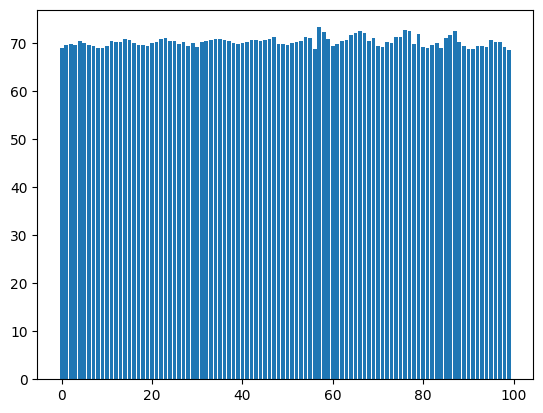

Ep 6253  avg_reward_20=129.35  avg_duration_20=86.65  avg_loss_100=3.9291


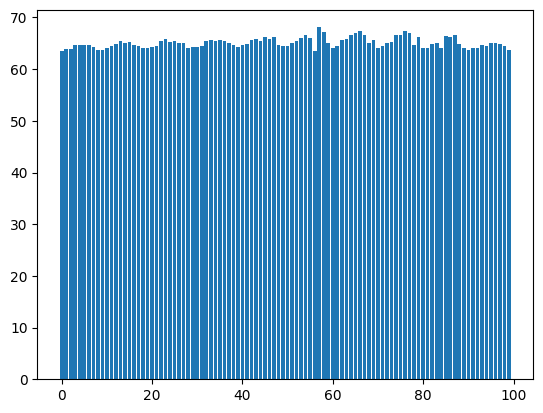

Ep 6303  avg_reward_20=129.70  avg_duration_20=86.30  avg_loss_100=3.8773


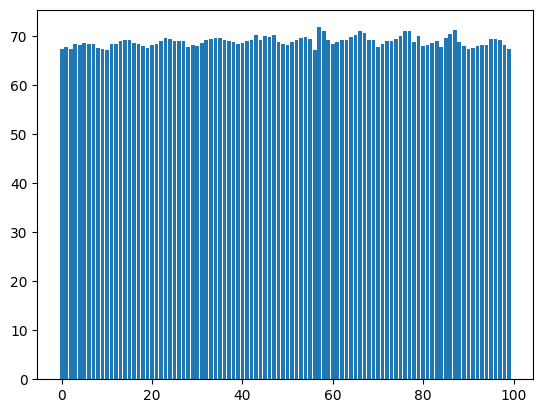

Ep 6353  avg_reward_20=131.30  avg_duration_20=84.70  avg_loss_100=4.0243
Weights moved at step: 560000


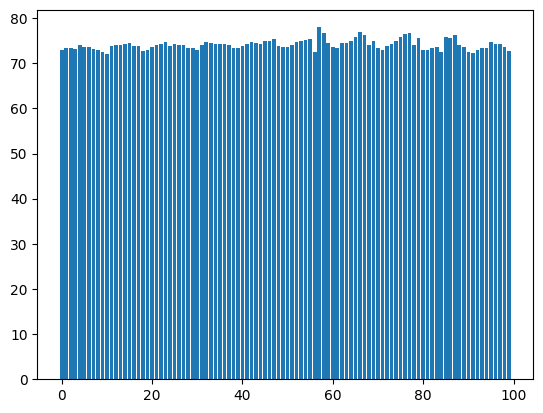

Ep 6403  avg_reward_20=129.75  avg_duration_20=86.25  avg_loss_100=4.5527


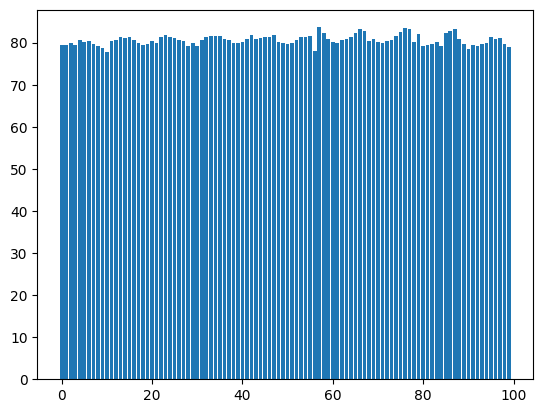

Ep 6453  avg_reward_20=132.25  avg_duration_20=83.75  avg_loss_100=4.5401


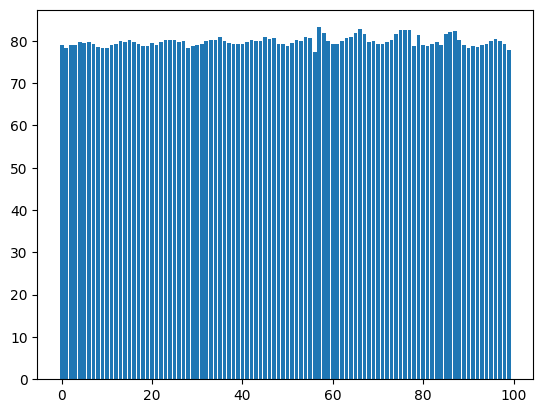

Ep 6503  avg_reward_20=130.90  avg_duration_20=85.10  avg_loss_100=4.3312


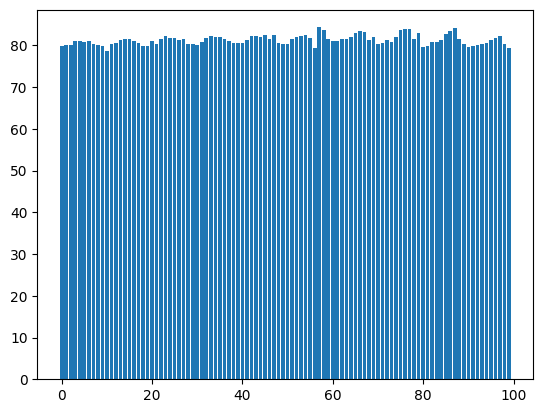

Ep 6553  avg_reward_20=130.10  avg_duration_20=85.90  avg_loss_100=4.7149
Weights moved at step: 580000


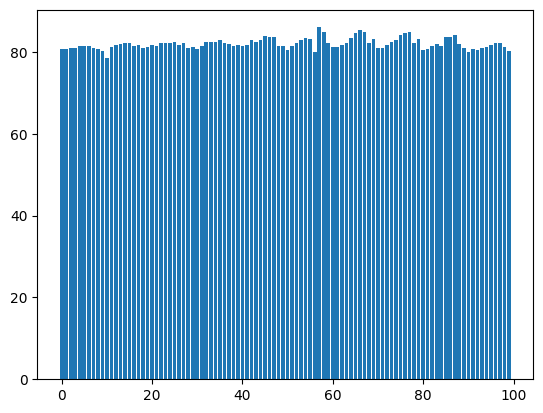

Ep 6603  avg_reward_20=128.25  avg_duration_20=87.75  avg_loss_100=5.5965


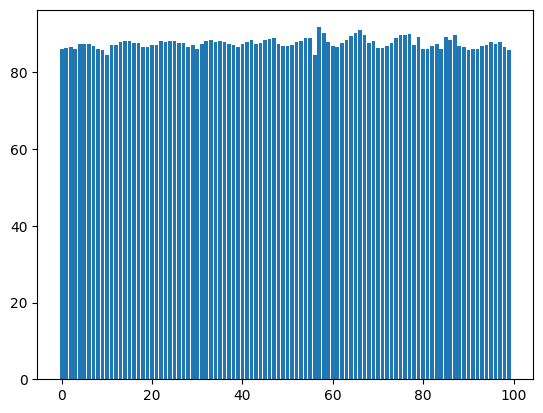

Ep 6653  avg_reward_20=129.45  avg_duration_20=86.55  avg_loss_100=5.1336


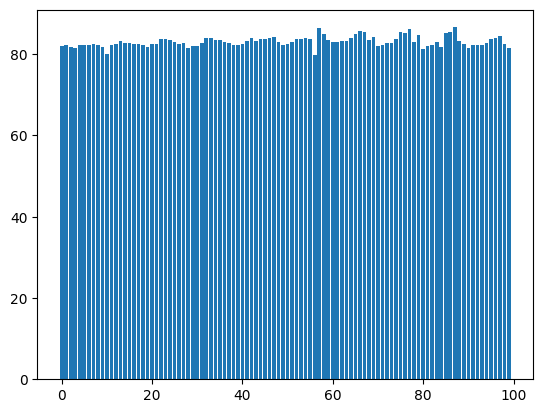

Ep 6703  avg_reward_20=132.95  avg_duration_20=83.05  avg_loss_100=5.0338


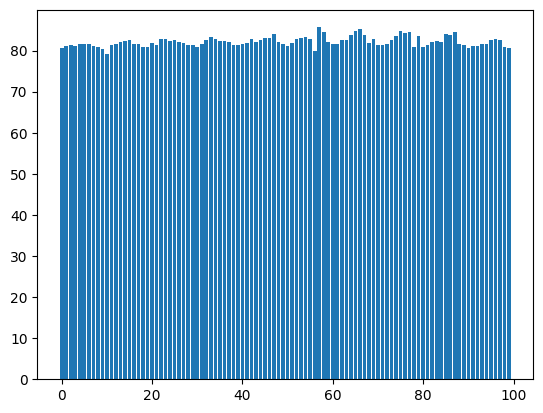

Ep 6753  avg_reward_20=128.20  avg_duration_20=87.80  avg_loss_100=5.0084


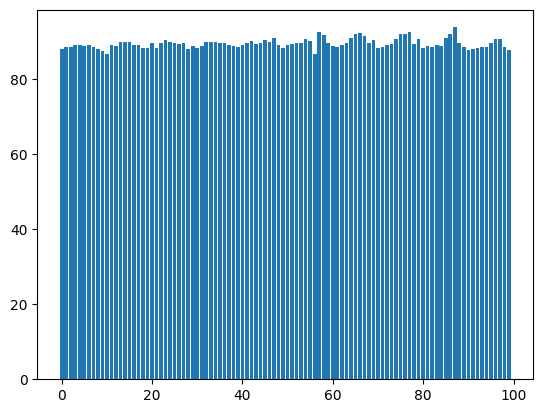

Ep 6803  avg_reward_20=128.00  avg_duration_20=88.00  avg_loss_100=4.7353
Weights moved at step: 600000


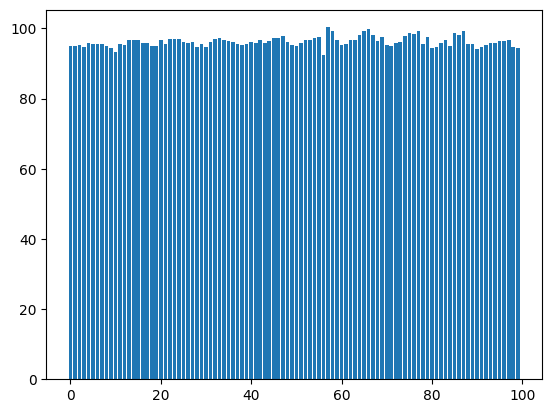

Ep 6853  avg_reward_20=132.45  avg_duration_20=83.55  avg_loss_100=5.5220


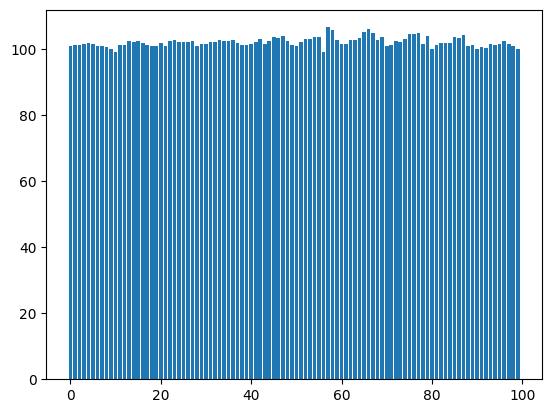

Ep 6903  avg_reward_20=130.05  avg_duration_20=85.95  avg_loss_100=5.5052


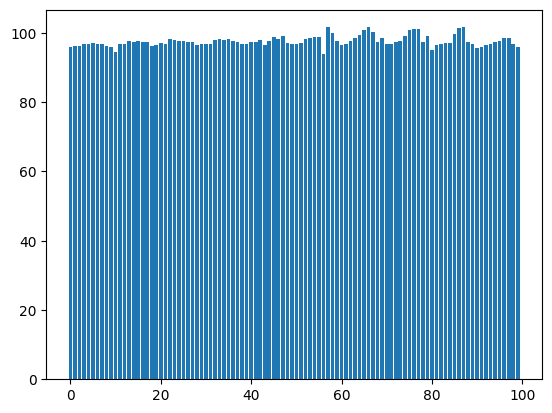

Ep 6953  avg_reward_20=126.40  avg_duration_20=89.60  avg_loss_100=5.7364


In [305]:
# single training loop, no double‐loops, no soft updates:
for i_episode in range(num_episodes + 1000, num_episodes + 2000):
    state = env.reset()
    state = torch.tensor(state, device=device).unsqueeze(0)
    total_reward = 0.0

    for t in count():
    # for t in range(1):
        action = select_action(state)
        obs, reward, done = env.step(action.item())
        total_reward += reward
        reward_t = torch.tensor([reward], device=device)
        next_state = None if done else torch.tensor(obs, device=device).unsqueeze(0)

        memory.push(state, action, next_state, reward_t)
        state = next_state

        optimize_model()

        if steps_done % TARGET_UPDATE_STEPS == 0:
            target_net_state_dict = target_net.state_dict()
            q_net_state_dict = q_net.state_dict()
            for key in q_net_state_dict:
                # target_net_state_dict[key] = q_net_state_dict[key]*tau + target_net_state_dict[key]*(1-tau)
                target_net_state_dict[key] = q_net_state_dict[key]
            target_net.load_state_dict(target_net_state_dict)

            print(f'Weights moved at step: {steps_done}')

        if done:
            episode_rewards.append(total_reward)
            episode_durations.append(t + 1)
            break


    # hard update every N episodes
    # if i_episode % TARGET_UPDATE_EPISODES == 0:
    #     target_net.load_state_dict(q_net.state_dict())

    if i_episode % 50 == 3:
        writer.add_scalar('Epsilon', 0.9 if steps_done < EPS_WARMUP else max(EPS_END, EPS_START - (EPS_START - EPS_END) * (steps_done - EPS_WARMUP) / EPS_DECAY), i_episode)


        for name, act in activation_stats.items():
            writer.add_scalar(f'Activation/{name}_mean', act.mean().item(), i_episode)
            writer.add_scalar(f'Activation/{name}_std', act.std().item(), i_episode)
            writer.add_scalar(f'Activation/{name}_max', act.abs().max().item(), i_episode)

        # print(activation_stats['fc2'].mean(dim=0).shape)
        plt.bar(np.arange(100), activation_stats['fc2'].mean(dim=0).cpu().numpy())
        plt.show()

        avg_r = sum(episode_rewards[-20:]) / min(20, len(episode_rewards))
        avg_l = sum(loss_history[-100:]) / min(len(loss_history), 100)
        avg_duration = sum(episode_durations[-20:]) / min(20, len(episode_durations))
        print(f"Ep {i_episode}  avg_reward_20={avg_r:.2f}  avg_duration_20={avg_duration:.2f}  avg_loss_100={avg_l:.4f}")

        writer.add_scalar('Reward/episode', avg_r, i_episode)
        writer.add_scalar('Duration/episode', avg_duration, i_episode)
        writer.add_scalar('Loss/last', avg_l, i_episode)

In [300]:
torch.set_grad_enabled(True)

In [281]:
writer.close()

In [306]:
torch.save(q_net.state_dict(), "checkpoints/dqn_battleship1_7000.pt")

In [ ]:
print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

In [ ]:
env = BattleshipEnv()
num_episodes = 1

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_reward = 0
    steps = 0

    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    while not done:
        # action = select_action(state)
        # print(action)
        print(q_net(state).max(1).indices.view(1, 1))
        obs, reward, done = env.step(action.item())
        total_reward += reward
        steps += 1
    print(f"Episode {episode+1}: Steps={steps}, Total Reward={total_reward}")